<a href="https://colab.research.google.com/github/Bengisunz/Data-Analytics-and-Machine-Learning-Projects/blob/master/Causal_Inference_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference Example





In [1]:
%%capture
!pip install pycausalimpact

In [18]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from google.colab import files
import statsmodels.formula.api as smf
import statsmodels.api as sm
from causalimpact import CausalImpact


%matplotlib inline

random.seed(20221216)

# Data exploration

We will analyze sales in a chain of flower stores like blumen 2020 in Germany.

Our task is to analyze results of the change.

In [38]:
import pandas as pd
import numpy as np

# Number of stores
total_stores = 97
treated_stores = 10
untreated_stores = total_stores - treated_stores

# Create data for store_name and store_treated
store_names = ["store_" + str(i).zfill(5) for i in range(1, total_stores + 1)]
store_treated = [1] * treated_stores + [0] * untreated_stores

# Create a date range for each store
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2015-07-31')

# Generate dates for all stores in the specified range
date_range = pd.date_range(start_date, end_date)

# Define intervention date
intervention_date = pd.to_datetime('2015-05-01')

# Create an empty list to store all dates for all stores
all_dates = []

# Loop through each store and add dates to the list
for _ in range(total_stores):
    all_dates.extend(date_range)

# Create the DataFrame with the generated dates
data = {'store_name': store_names * len(date_range),
        'store_treated': store_treated * len(date_range),
        'date': all_dates,
        'dayofweek': np.random.randint(1, 8, total_stores * len(date_range)),  # Generate random day of week
        'state_holiday': np.random.choice([0, 1], total_stores * len(date_range), p=[0.95, 0.05]),
        'school_holiday': np.random.choice([0, 1], total_stores * len(date_range), p=[0.8, 0.2]),
        'open': np.random.choice([0, 1], total_stores * len(date_range), p=[0.1, 0.9]),
        'promo': np.random.choice([0, 1], total_stores * len(date_range)),
        'sales': np.random.randint(5000, 15000, total_stores * len(date_range)),
        'customers': np.random.randint(100, 1000, total_stores * len(date_range))
       }

df = pd.DataFrame(data)

# Create the period column with the adjusted logic
df['period'] = np.where(df['date'] < intervention_date, 'pre intervention', 'post intervention')

# Extract store number
df['store'] = df['store_name'].astype(str).str[-5:].astype(int)

# Print first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))


| store_name   | store_treated   | date                | dayofweek   | state_holiday   | school_holiday   | open   | promo   | sales   | customers   | period           | store   |
|:-------------|:----------------|:--------------------|:------------|:----------------|:-----------------|:-------|:--------|:--------|:------------|:-----------------|:--------|
| store_00001  | 1               | 2015-01-01 00:00:00 | 6           | 0               | 1                | 0      | 0       | 8010    | 299         | pre intervention | 1       |
| store_00002  | 1               | 2015-01-02 00:00:00 | 4           | 1               | 1                | 1      | 1       | 14397   | 780         | pre intervention | 2       |
| store_00003  | 1               | 2015-01-03 00:00:00 | 2           | 0               | 1                | 1      | 1       | 11078   | 772         | pre intervention | 3       |
| store_00004  | 1               | 2015-01-04 00:00:00 | 2           | 0               | 0          

**stores_data** dataset:
- *store*: a unique store ID,
- *store_name*: a unique store name,
- *store_treated*: whether a store was affected by the treatment or not, unique per store,
- *sales*: volume of sales in a given store on a given day,
- *customers*: number of customers that visited a given store on a given day,
- period: whether a given date is from before of after the treatment.


In [39]:
df.sample(4)

,store_name,store_treated,date,dayofweek,state_holiday,school_holiday,open,promo,sales,customers,period,store
6178,store_00068,0,2015-01-31,3,0,1,1,0,13224,142,pre intervention,68
13485,store_00003,1,2015-05-10,5,0,0,1,1,6287,657,post intervention,3
17209,store_00041,0,2015-02-07,5,0,0,1,0,5299,886,pre intervention,41
15450,store_00028,0,2015-07-06,7,0,0,1,0,11548,716,post intervention,28


In [44]:
# Let"s create collections of all stores, treated stores, and untreated stores
stores = list(df["store"].unique())
treated_stores = list(df.loc[df["store_treated"]==1, "store"].unique())
untreated_stores = list(df.loc[df["store_treated"]==0, "store"].unique())

print(f"All stores: {len(stores)}, treated stores: {len(treated_stores)}, untreated stores: {len(untreated_stores)}.")

All stores: 97, treated stores: 10, untreated stores: 87.


In [35]:
df.describe()

,store_treated,date,dayofweek,state_holiday,school_holiday,open,promo,sales,customers,store,weekofyear,week_date
count,47.000000,47,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.0,47
mean,0.127660,2015-06-28 21:03:19.949985536,3.808511,0.063830,0.127660,0.851064,0.510638,9715.063830,475.319149,51.148936,26.489362,2015-06-25 22:35:14.843602432
min,0.000000,2015-01-10 21:02:44.644144376,1.000000,0.000000,0.000000,0.000000,0.000000,5009.000000,107.000000,2.000000,2.0,2015-01-05 21:02:44.644144376
25%,0.000000,2015-03-21 11:17:29.354874368,2.000000,0.000000,0.000000,1.000000,0.000000,6919.000000,207.500000,28.500000,12.5,2015-03-19 23:17:29.354874368
50%,0.000000,2015-07-09 14:41:42.758164480,4.000000,0.000000,0.000000,1.000000,1.000000,9673.000000,407.000000,52.000000,28.0,2015-07-06 14:41:42.758164480
75%,0.000000,2015-09-23 07:44:15.694075904,6.000000,0.000000,0.000000,1.000000,1.000000,12165.000000,728.500000,75.500000,39.0,2015-09-21 07:44:15.694075904
max,1.000000,2015-12-21 10:34:25.833945544,7.000000,1.000000,1.000000,1.000000,1.000000,14860.000000,999.000000,97.000000,52.0,2015-12-21 10:34:25.833945544
std,0.337318,NaN,2.102155,0.247092,0.337318,0.359875,0.505291,2963.234847,280.542960,29.264891,15.229937,NaN


In [40]:
pre = sorted(df.loc[df["period"]=="pre intervention", "date"].unique())
pre_intervention = [pd.Timestamp(min(pre)).strftime("%Y-%m-%d"), pd.Timestamp(max(pre)).strftime("%Y-%m-%d")]

post = sorted(df.loc[df["period"]=="post intervention", "date"].unique())
post_intervention = [pd.Timestamp(min(post)).strftime("%Y-%m-%d"), pd.Timestamp(max(post)).strftime("%Y-%m-%d")]

print(f"original pre_intervention: {pre_intervention}")
print(f"original post_intervention: {post_intervention}")

original pre_intervention: ['2015-01-01', '2015-04-30']
original post_intervention: ['2015-05-01', '2015-07-31']


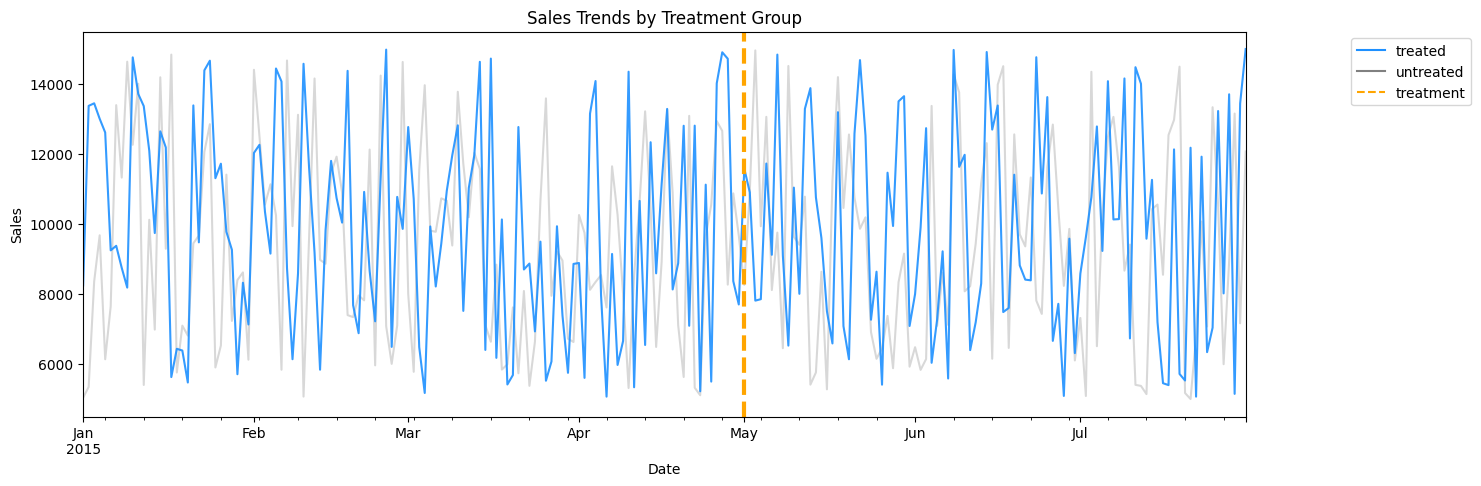

In [43]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_stores(df, treated, untreated, labels=['treated', 'untreated']):
    df_plot_untreated = df[df["store"].isin(untreated)] # Make sure the data type is correct.
    df_plot_treated = df[df["store"].isin(treated)]    # Make sure the data type is correct.

    df_plot_untreated = df_plot_untreated.pivot(
        index="date", columns="store", values="sales"
    )
    df_plot_treated = df_plot_treated.pivot(
        index="date", columns="store", values="sales"
    )

    figsize_size = (15, 5)
    fig, ax = plt.subplots(figsize=figsize_size)
    df_plot_untreated.plot(kind="line", ax=ax, alpha=0.3, color="grey")
    df_plot_treated.plot(kind="line", ax=ax, alpha=0.9, color="dodgerblue")
    plt.ylabel("Sales")
    plt.axvline(x=intervention_date, linestyle="--", color="orange", linewidth=3)  # Use intervention_date instead of post_intervention[0]

    treated_patch = mlines.Line2D(xdata=[0], ydata=[0], color="dodgerblue", linestyle="-", label=labels[0])
    untreated_patch = mlines.Line2D(xdata=[0], ydata=[0], color="grey", linestyle="-", label=labels[1])
    intervention_patch = mlines.Line2D(xdata=[0], ydata=[0], color="orange", linestyle="--", label="treatment")
    handles = [treated_patch, untreated_patch, intervention_patch]
    plt.legend(handles=handles, bbox_to_anchor=(1.2, 1))

    plt.xlabel("Date")
    plt.title("Sales Trends by Treatment Group")

    plt.show()
plot_stores(df, [treated_stores], [untreated_stores])


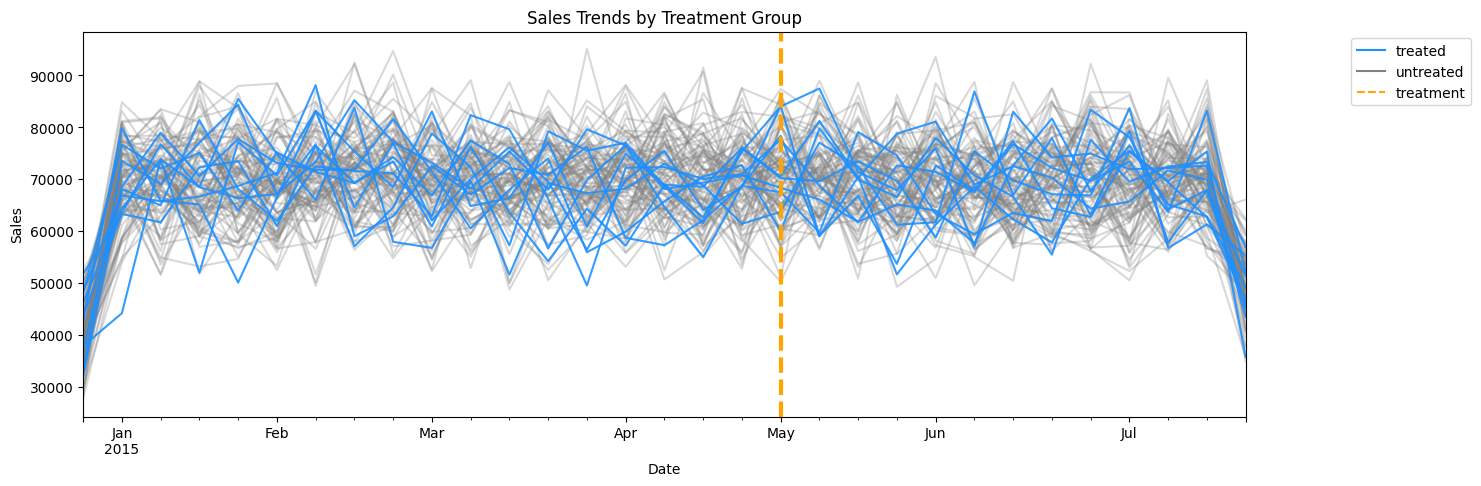

In [45]:
# Init inspection - aggreagte sales data by week

# Add week date
df["weekofyear"] = df["date"].dt.isocalendar().week
df["week_date"] = df["date"] - df["date"].dt.weekday * np.timedelta64(1, "D")
df_weekly = df.groupby(["week_date", "store"])["sales"].sum().reset_index().rename(columns={"week_date": "date"})

# Plot treated stores in blue
plot_stores(df_weekly, treated_stores, untreated_stores)

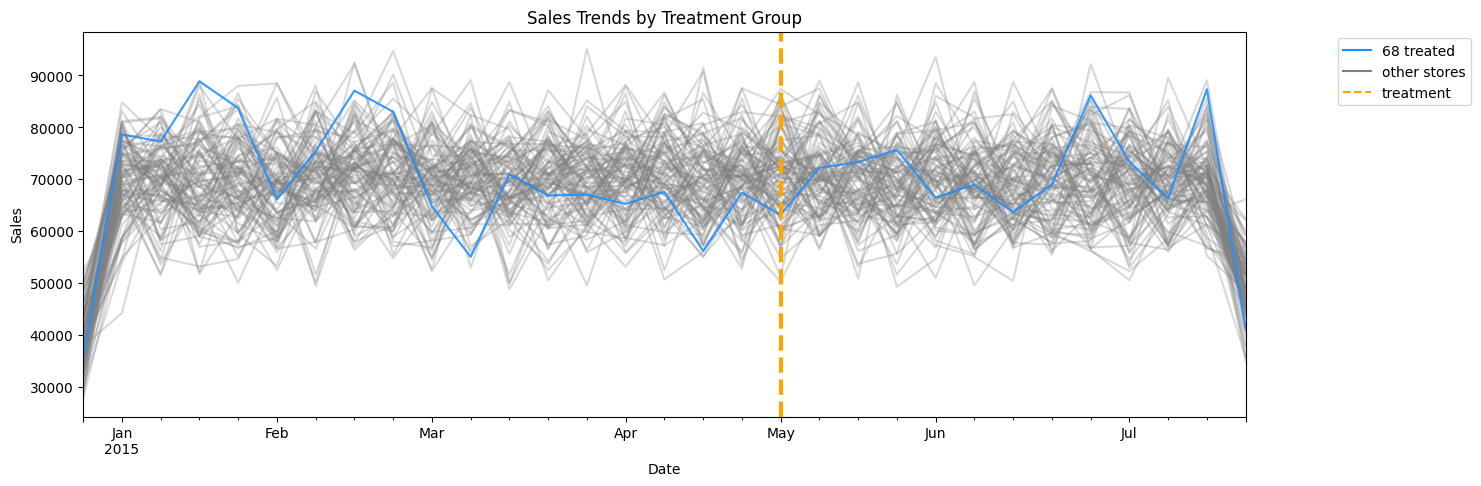

In [47]:
experiment_store = 68
other_stores = [s for s in stores if s != experiment_store]

plot_stores(df_weekly, [experiment_store], other_stores, labels=[f"{experiment_store} treated", "other stores"])

# Difference-in-Differences

In [51]:
# Create a balanced sample of treated and untreated stores
treated_stores_did = random.sample(treated_stores, 10)
untreated_stores_did = random.sample(untreated_stores, 10)
stores_did = treated_stores_did + untreated_stores_did

df_did = df[df["store"].isin(stores_did)]

# Convert period variable to dummy
df_did["period_v2"] = np.where(df_did["period"]=="post intervention", 1, 0)

# Add `intervention` variable which will be equal to 1 when a store at a given time was affected by the treatment
df_did["intervention"] = np.where((df_did["store_treated"]==1) & (df_did["period"]=="post intervention"), 1, 0)

# df_did["sales"] = df_did["sales"]/df_did["sales"].mean()

<ipython-input-51-bc09e8a82759>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_did["period_v2"] = np.where(df_did["period"]=="post intervention", 1, 0)
<ipython-input-51-bc09e8a82759>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_did["intervention"] = np.where((df_did["store_treated"]==1) & (df_did["period"]=="post intervention"), 1, 0)


In [52]:
df_did.head(4)

,store_name,store_treated,date,dayofweek,state_holiday,school_holiday,open,promo,sales,customers,period,store,weekofyear,week_date,period_v2,intervention
0,store_00001,1,2015-01-01,6,0,1,0,0,8010,299,pre intervention,1,1,2014-12-29,0,0
1,store_00002,1,2015-01-02,4,1,1,1,1,14397,780,pre intervention,2,1,2014-12-29,0,0
2,store_00003,1,2015-01-03,2,0,1,1,1,11078,772,pre intervention,3,1,2014-12-29,0,0
3,store_00004,1,2015-01-04,2,0,0,1,0,6804,911,pre intervention,4,1,2014-12-29,0,0


In [53]:
# The basic approach
model_did_0 = smf.ols(formula = "sales ~ store_treated + period_v2 + intervention", data = df_did).fit()
print(model_did_0.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.683
Date:                Thu, 20 Jun 2024   Prob (F-statistic):              0.168
Time:                        15:18:03   Log-Likelihood:                -39821.
No. Observations:                4240   AIC:                         7.965e+04
Df Residuals:                    4236   BIC:                         7.968e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9853.4483     83.793    117.593

The Difference-in-Differences (DiD) model results presented in the image suggest the following:

**Model:**

The model estimates the impact of an intervention (e.g., a policy change, new product introduction) on sales. The variables included in the model are:

* **store_treated:** A binary variable indicating whether a store is in the treatment group (1) or control group (0).
* **period_v2:** A binary variable indicating the time period (pre- or post-intervention).
* **intervention:** The interaction term between `store_treated` and `period_v2`. This is the key variable of interest in the DiD model, as it captures the differential effect of the intervention on the treated group compared to the control group.

**Interpretation of Coefficients:**

* **Intercept (9853.4483):** The estimated average sales for the control group in the pre-intervention period.
* **store_treated (68.6842):** The estimated average difference in sales between the treated and control groups before the intervention. However, it's not statistically significant (P>|t| = 0.562), suggesting no significant difference between the groups before the intervention.
* **period_v2 (278.6614):** The estimated average change in sales over time (from pre- to post-intervention) for the control group. This is statistically significant (P>|t| = 0.029), indicating a significant increase in sales over time for stores not exposed to the intervention.
* **intervention (-241.9700):** The estimated average treatment effect, representing the difference in the change in sales between the treated and control groups after the intervention. This is the primary quantity of interest in the DiD model. However, it is not statistically significant (P>|t| = 0.179), suggesting that we cannot confidently conclude that the intervention had a causal impact on sales.

**Overall Conclusion:**

While the model controls for time trends and differences between groups, the results indicate that the intervention did not have a statistically significant effect on sales. The observed difference in sales changes between the treated and control groups could be due to random chance rather than the intervention itself.

**Possible Limitations and Considerations:**

* **Parallel Trends Assumption:** The DiD model relies on the assumption that the treated and control groups would have followed parallel trends in sales in the absence of the intervention. This assumption might not hold, leading to biased estimates. You can check for parallel trends by plotting the average sales for both groups over time before the intervention.
* **Omitted Variables:** There could be other unobserved factors affecting sales that are not accounted for in the model. These omitted variables could confound the estimated treatment effect.
* **Small Sample Size:** If the sample size is small, the model might not have enough statistical power to detect a significant effect, even if one exists.

**Next Steps:**

* **Check Parallel Trends:** Verify if the parallel trends assumption holds before drawing any definitive conclusions.
* **Include Control Variables:** If possible, consider adding more control variables to the model to account for potential confounding factors.
* **Sensitivity Analysis:** Conduct sensitivity analyses to assess the robustness of the results to different model specifications and assumptions.

Let me know if you have any further questions or would like me to elaborate on any aspect of the interpretation.


In [28]:
# Is it correct to use number of customers
model_did_1 = smf.ols(formula = "sales ~ state_holiday + school_holiday + open + customers + store_treated + period_v2 + intervention", data = df_did).fit()
print(model_did_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     6.309
Date:                Thu, 20 Jun 2024   Prob (F-statistic):             0.0221
Time:                        14:54:55   Log-Likelihood:                -100.41
No. Observations:                  12   AIC:                             212.8
Df Residuals:                       6   BIC:                             215.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4107.4326    955.594      4.

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [29]:
model_did_2 = smf.ols(formula = "sales ~ state_holiday + school_holiday + open + store_treated + period_v2 + intervention", data = df_did).fit()
print(model_did_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     8.697
Date:                Thu, 20 Jun 2024   Prob (F-statistic):            0.00753
Time:                        14:54:57   Log-Likelihood:                -100.69
No. Observations:                  12   AIC:                             211.4
Df Residuals:                       7   BIC:                             213.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4056.5000    901.316      4.

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


# References

https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html